# Objective:

* To use a Neural Network NN to predict shock strength and location for an inviscid one-dimensional steady compressible flow in a nozzle

* To enhance the quality of the predictions using governing physical laws of the problem to form a Physics Informed Neural Network PINN

## Introduction:

NNs and PINNs are a dense network of small functions, i.e. weighted linear combinations and non-linear operators which have the capability of predicting an output variable given the true output value by minimising the difference, referred as loss between them. PINNs take this a level further by predicting the value of governing equations *e* in addition to the output variables by minimising the complete loss between all the predictions and their respective true values which is zero for the governing equations.

The steady compressible equations of this problem are:

$$\frac{\partial {(\rho uS)}}{\partial x} = 0 \quad\quad\quad\quad\quad\quad\quad\quad(e_1) $$

$$\frac{\partial {[(\rho u^2 + P)S]}}{\partial x} - p\frac{\partial S} {\partial x} =0\quad\quad(e_2)$$

$$\frac{\partial {(\rho EuS)}}{\partial x} = 0\quad\quad\quad\quad\quad\quad\quad(e_3)$$

The ideal gase euation is given by: $$p- \rho {(\gamma-1)}{(E-\frac{u^2}{2})} = 0\quad\quad(e_4)$$

Here, *$\rho$* is density, *p* is pressure, *u* is velocity and *E* is specific energy.

### Loss Definition for NN and PINN:
* Loss for NN which is the mean squared error MSE is given by: $$NN_{Loss} = MSE = \frac{1}{N_s}\sum_{k=1}^{N_s} (y_{i}^{pred} -y_{i}^{truth})^2 $$

  Here, *y* is an output variable and $N_s$ is the number of datapoints in the dataset.

  **Note:** In case of multi-varaible prediction MSE is summed over all the output variables.
  

* Loss for PINN is given by: $$PINN_{Loss} = MSE + RES = \frac{1}{N_s}\sum_{k=1}^{N_o}\sum_{i=1}^{N_s} (y_{ik}^{pred} -y_{ik}^{truth})^2 + \frac{1}{N_s}\sum_{j=1}^{N_e}\sum_{i=1}^{N_s} (e_{ij}^2)$$

  Here, $N_o$ and $N_e$ reperesent the number of output variables and governing equations respectively. 
  
  **Note:** RES is infact the MSE corresponding to *e* as $e^{truth}$ is equal to zero.

### Analogy to the closed loop control system:
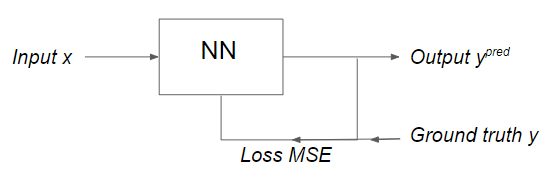  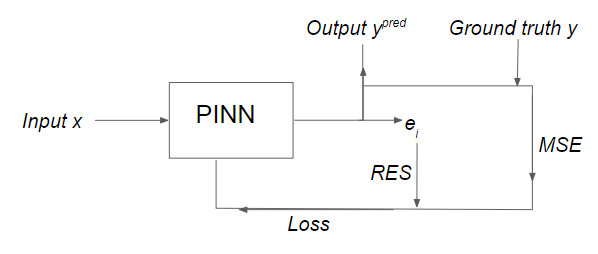 

### Architecture: 
* Input Variables: Back Pressure $P_b$, location *x* from the nozzle inlet
* Output Variables: Pressure p , Density $\rho$, Velocity u, Specific Energy E

## NN
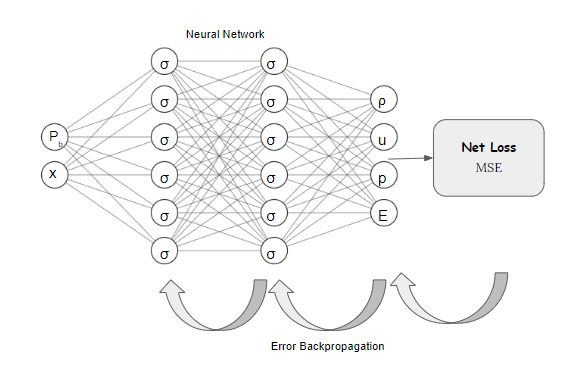  

## PINN
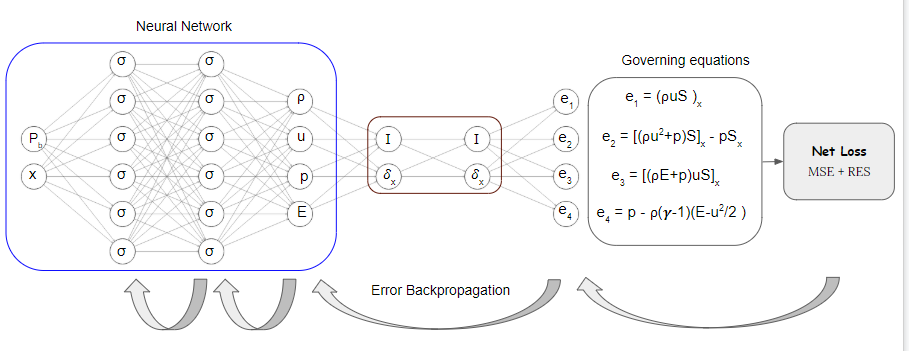

# Code:

The above command imports all the necessary python libraries reuired to run the code

In [1]:
import sys
sys.path.insert(0, '../../Utilities/')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
import time
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
#from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import csv

Defining all the input and output variables

In [28]:
global P_back, rho, u, E, P, x

Initialising a fixed instance of a random state to produce consistent results each time the code is run

In [29]:
np.random.seed(1234)
tf.set_random_seed(1234)

*The function **model_init** takes in the training data (input as well as output) along with a variable called as layers which is an array representing the network architecture i.e. the length of array represents the number of layers and each element represents the number of neurons in a particular layer.*

* Weights and Biases are initialised using a function called initialise_NN by taking *layers* as input.

* At first, Tensorflow creates a session wherein a computational graph containing all the operations is defined using an object called placeholder, which can be considered as a variable that doesn't need to be initialised any value. Placeholders are defined for all input and output variables and data is later fed into these placeholders while training the network with a uniquely defined operation sequence. 

* *net_NS* function takes the input placeholders, weights and biases matrix and outputs the flow variable as well as the governing equation predictions.

* A loss function is defined using the predictions and the ground truth values which is later fed into the ADAM optimizer. In addition to ADAM, an 'L-BFGS-B' optimiser is also initialised to make sure that the loss reaches its global minima at the end of training the network.


In [30]:
def model_init(P_back, x, P, rho, u, E, layers):

    global lb, ub, X, weights, biases, sess
    global P_back_tf, x_tf, P_tf, rho_tf, u_tf, E_tf
    global P_pred, rho_pred, u_pred, E_pred

    X = np.concatenate([P_back, x], 1)

    lb = X.min(0)
    ub = X.max(0)
    
    # Initialize NN
    weights, biases = initialize_NN(layers)        
    
    # tf placeholders and graph
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                 log_device_placement=True))
    
    P_back_tf = tf.placeholder(tf.float32, shape=[None, P_back.shape[1]])
    x_tf = tf.placeholder(tf.float32, shape=[None, x.shape[1]])
    P_tf = tf.placeholder(tf.float32, shape=[None, P.shape[1]])
    rho_tf = tf.placeholder(tf.float32, shape=[None, rho.shape[1]])
    u_tf = tf.placeholder(tf.float32, shape=[None, u.shape[1]])
    E_tf = tf.placeholder(tf.float32, shape=[None, E.shape[1]])
    
    P_pred, rho_pred, u_pred, E_pred, e1, e2, e3, e4 = net_NS(P_back_tf, x_tf, weights, biases)

    # MSE Normalization
    P_norm = np.amax(P)
    rho_norm = np.amax(rho)
    u_norm = np.amax(u)
    E_norm = np.amax(E)
    S_norm = 5.95
    e1_norm = rho_norm*u_norm*S_norm
    e2_norm = P_norm*S_norm
    e3_norm = E_norm*rho_norm*u_norm*S_norm
    w = 40

    global loss
    loss = tf.reduce_sum(tf.square(P_tf - P_pred))/(P_norm**2) + \
                tf.reduce_sum(tf.square(rho_tf - rho_pred))/(rho_norm**2) + \
                tf.reduce_sum(tf.square(u_tf - u_pred))/(u_norm**2) + \
                tf.reduce_sum(tf.square(E_tf - E_pred))/(E_norm**2) + \
                w*tf.reduce_sum(tf.square(e2))/(e2_norm**2) + \
                w*tf.reduce_sum(tf.square(e3))/(e3_norm**2) + \
                w*tf.reduce_sum(tf.square(e1))/(e1_norm**2) + \
                w*tf.reduce_sum(tf.square(e4))/(P_norm**2)
    
    global optimizer
    optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss, 
                                                            method = 'L-BFGS-B', 
                                                            options = {'maxiter': 15000,
                                                                       'maxfun': 15000,
                                                                       'maxcor': 50,
                                                                       'maxls': 50,
                                                                       'ftol' : 1.0 * np.finfo(float).eps})        
    
    optimizer_Adam = tf.train.AdamOptimizer()
    global train_op_Adam
    train_op_Adam = optimizer_Adam.minimize(loss)                    
    
    init = tf.global_variables_initializer()
    sess.run(init)

* For each layer, the size of weight matrix depends on the number of neurons in the current as well as the next layer.
* The weights are initialised values through random selection from a Gaussian distribution with zero mean and specified variance.
* The size of bias vector depends on the number of neurons in the next layer.
* The biases are intialised as zero.

In [31]:
def initialize_NN(layers):        
    weights = []
    biases = []
    num_layers = len(layers) 
    for l in range(0,num_layers-1):
        W = xavier_init(size=[layers[l], layers[l+1]])
        b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
        weights.append(W)
        biases.append(b)        
    return weights, biases

In [32]:
def xavier_init(size):
    in_dim = size[0]
    out_dim = size[1]        
    xavier_stddev = np.sqrt(2/(in_dim + out_dim))
    return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

The *neural_net* defines the feedforward function from input variables to output variables, given weights and biases. This dense function is a network of small functions which are the weighted linear combinations and tanh, which is the non-linear activation in this problem.

In [33]:
def neural_net(X, weights, biases):
    num_layers = len(weights) + 1
    
    H = 2.0*(X - lb)/(ub - lb) - 1.0
    for l in range(0,num_layers-2):
        W = weights[l]
        b = biases[l]
        H = tf.tanh(tf.add(tf.matmul(H, W), b))
    W = weights[-1]
    b = biases[-1]
    Y = tf.add(tf.matmul(H, W), b)
    return Y

The *net_NS* takes in the input variables and weights, and outputs the flow varibles by calling *neural_net*. In addition to this, the function also computes the governing equation residuals using Automatic Differentiaton through the output flow variables.

In [34]:
def net_NS(P_back, x, weights, biases):
    P_rho_u_E = neural_net(tf.concat([P_back, x], 1), weights, biases)
    P = P_rho_u_E[:,0:1]
    rho = P_rho_u_E[:,1:2]
    u = P_rho_u_E[:,2:3]
    E = P_rho_u_E[:,3:4]

    S = 1 + 2.2*(3*x-1.5)**2
    # autodiff gradient #1
    mass_flow_grad = tf.gradients(rho*u*S, x)[0]
    # autodiff gradient #2
    momentum_grad = tf.gradients((rho*u*u + P)*S, x)[0] - P*tf.gradients(S, x)[0]
    # autodiff gradient #3
    energy_grad = tf.gradients((rho*E + P)*u*S, x)[0]
    # state residual
    gamma = 1.4
    state_res = P - rho*(gamma-1)*(E-0.5*gamma*u*u)

    return P, rho, u, E, mass_flow_grad, momentum_grad, energy_grad, state_res

The callback function prints loss value on the command terminal.

In [35]:
def callback(loss):
    loss_vector.append(loss)
    print('Loss: %.3e' % (loss))

The *train* function takes in the training data and number of iterations or epochs as input and prints the loss value on the command terminal.

* Training data is fed into the placeholders using a dictionary data sturucture. The wieghts are updated at every epoch by running the ADAM optimiser session with the dictionary.
* ADAM optimiser requires the number of iterations as a parameter and prints the loss value after every 1000th iteration.
* To make sure that the loss value reaches its global minima, the weights are also updated using L-BFGS optimiser after ADAM.

In [36]:
def train(nIter, P_back, x, rho, u, E, P):

    tf_dict = {P_back_tf: P_back, x_tf: x,
                P_tf: P, rho_tf: rho, u_tf: u, E_tf: E
                }
    
    global loss_vector
    loss_vector = []

    start_time = time.time()
    for it in range(nIter):
        sess.run(train_op_Adam, tf_dict)

        loss_value = sess.run(loss, tf_dict)
        loss_vector.append(loss_value)

        # Print
        if it % 1000 == 0:
            elapsed = time.time() - start_time
            # res1 = self.sess.run(self.e1, tf_dict)
            # res2 = self.sess.run(self.e2, tf_dict)
            # res3 = self.sess.run(self.e3, tf_dict)
            print('Iter: %d, Loss: %.3e, Time: %.2f' % 
                  (it, loss_value, elapsed))
            # print('Mass Residual: %f\t\tMomentum Residual: %f\tEnergy Residual: %f'
            #     %(sum(map(lambda a:a*a,res1))/len(res1), sum(map(lambda a:a*a,res2))/len(res2), sum(map(lambda a:a*a,res3))/len(res3)))
            start_time = time.time()
        
     optimizer.minimize(sess,
                         feed_dict = tf_dict,
                         fetches = [loss],
                         loss_callback = callback)

    #return loss_vector

The trained network is used to predict the output flow variables on the test dataset using *predict* function. 

In [37]:
def predict(P_back_test, x_test):
    tf_dict = {P_back_tf: P_back_test, x_tf: x_test}
    P_test = sess.run(P_pred, tf_dict)
    rho_test = sess.run(rho_pred, tf_dict)
    u_test = sess.run(u_pred, tf_dict)
    E_test = sess.run(E_pred, tf_dict)
    return P_test, rho_test, u_test, E_test

*Layers* vector is defined in the main function. For this problem, 2 input variables, 4 output variables and 3 hidden layers having 10 neurons each are taken as network architecture.

In [38]:
layers = [2, 10, 10, 10, 4]

A mother dataset is created by importing csv files generated from an analytical compressible nozzle flow solver.

In [39]:
P_dataset = []
rho_dataset = []
E_dataset = []
u_dataset = []

with open('cdn_P.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        for element in row:
            P_dataset.append(float(element))

with open('cdn_rho.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        for element in row:
            rho_dataset.append(float(element))

with open('cdn_E.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        for element in row:
            E_dataset.append(float(element))

with open('cdn_u.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        for element in row:
            u_dataset.append(float(element))

P_dataset = np.asarray(P_dataset)
rho_dataset = np.asarray(rho_dataset)
E_dataset = np.asarray(E_dataset)
u_dataset = np.asarray(u_dataset)

In [40]:
P_back_all = []
P_back_all = np.asarray(P_all)
x_all = []
x_all = np.asarray(x_all)

for i in range(0, 27):
    P_back_value = 0.01*(21+3*i)*np.ones((101,1))
    P_back_all = np.concatenate((P_back_all, P_back_value), axis=None)
    x_value = 0.01*np.arange(0, 101, dtype=float).flatten()[:,None]
    x_all = np.concatenate((x_all, x_value), axis=None)

Training data is generated by randomly selecting 1% points from the mother dataset. *N_train* shows the number of data points used for training the network.

In [41]:
train_frac = 0.01

In [42]:
N_train = int(train_frac*P_dataset.shape[0])

np.random.choice randomly selects a fraction of indices which are later used to slice the mother dataset to form a training dataset.

In [43]:
A = np.random.choice(range(P_dataset.shape[0]), size=(N_train,), replace=False)

In [44]:
# x
P_back_train = P_back_all[A].flatten()[:,None]
x_train = x_all[A].flatten()[:,None]
# y
P_train = P_dataset[A].flatten()[:,None]
rho_train = rho_dataset[A].flatten()[:,None]
u_train = u_dataset[A].flatten()[:,None]
E_train = E_dataset[A].flatten()[:,None]

* The training dataset is fed into the *model_init* function containing a pre-defined computational graph thus initialising placeholder values in the network.
* The *train* function starts the training marked by simultaneous feedforward and backpropogation computations resulting in updation of weights and biases.

In [45]:
# Training
model_init(P_back_train, x_train, P_train, rho_train, u_train, E_train, layers)
train(20001, P_back_train, x_train, rho_train, u_train, E_train, P_train_frac)

Iter: 0, Loss: 1.074e+02, Time: 0.76
Iter: 1000, Loss: 9.807e+00, Time: 2.27
Iter: 2000, Loss: 7.337e+00, Time: 2.27
Iter: 3000, Loss: 2.674e+00, Time: 2.40
Iter: 4000, Loss: 1.902e+00, Time: 2.58
Iter: 5000, Loss: 1.380e+00, Time: 2.28
Iter: 6000, Loss: 1.114e+00, Time: 2.29
Iter: 7000, Loss: 9.564e-01, Time: 2.28
Iter: 8000, Loss: 8.627e-01, Time: 2.29
Iter: 9000, Loss: 7.935e-01, Time: 2.28
Iter: 10000, Loss: 7.382e-01, Time: 2.29
Iter: 11000, Loss: 6.881e-01, Time: 2.28
Iter: 12000, Loss: 6.438e-01, Time: 2.27
Iter: 13000, Loss: 6.268e-01, Time: 2.29
Iter: 14000, Loss: 5.624e-01, Time: 2.28
Iter: 15000, Loss: 5.262e-01, Time: 2.28
Iter: 16000, Loss: 4.950e-01, Time: 2.28
Iter: 17000, Loss: 4.681e-01, Time: 2.29
Iter: 18000, Loss: 4.437e-01, Time: 2.46
Iter: 19000, Loss: 4.222e-01, Time: 2.36
Iter: 20000, Loss: 7.686e-01, Time: 2.29


In [46]:
# plt.plot(loss_vector, label='Loss value')
# print("Total Iter = " + str(len(loss_vector)))
# plt.legend()
# plt.title('Loss value over iterations')
# plt.xlabel('#iterations')
# plt.ylabel('Loss')
# plt.show()

The test dataset corresponding to 6 different back pressures for all x values is generated using the same analytical nozzle flow solver

In [47]:
# Test Data
P_test_dataset = []
rho_test_dataset = []
E_test_dataset = []
u_test_dataset = []

with open('cdn_P_test.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        for element in row:
            P_test_dataset.append(float(element))

with open('cdn_rho_test.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        for element in row:
            rho_test_dataset.append(float(element))

with open('cdn_E_test.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        for element in row:
            E_test_dataset.append(float(element))

with open('cdn_u_test.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        for element in row:
            u_test_dataset.append(float(element))

P_test_dataset = np.asarray(P_test_dataset).flatten()[:,None]
rho_test_dataset = np.asarray(rho_test_dataset).flatten()[:,None]
E_test_dataset = np.asarray(E_test_dataset).flatten()[:,None]
u_test_dataset = np.asarray(u_test_dataset).flatten()[:,None]

In [48]:
P_back_test=[]
P_back_test=np.asarray(P_back_test)
x_test=[]
x_test=np.asarray(x_test)

for i in range(0, 6):
    P_back_value = 0.01*(35+10*i)*np.ones((101,1))
    P_back_test = np.concatenate((P_back_test, P_back_value), axis=None)
    x_value = 0.01*np.arange(0, 101, dtype=float).flatten()[:,None]
    x_test = np.concatenate((x_test, x_value), axis=None)

P_back_test = P_back_test.flatten()[:,None]
x_test = x_test.flatten()[:,None]

Test data predictions are obtained using the *predict* function and normalised mean test error for all flow variables is calculated.

In [49]:
# Prediction
P_test_pred, rho_test_pred, u_test_pred, E_test_pred  = predict(P_back_test, x_test)

In [50]:
# Error
P_test_error = np.linalg.norm(P_test_dataset-P_test_pred,2)/np.linalg.norm(P_test_dataset,2)
print("Test Error in P: "+str(P_test_error))

rho_test_error = np.linalg.norm(rho_test_dataset-rho_test_pred,2)/np.linalg.norm(rho_test_dataset,2)
print("Test Error in rho: "+str(rho_test_error))

u_test_error = np.linalg.norm(u_test_dataset-u_test_pred,2)/np.linalg.norm(u_test_dataset,2)
print("Test Error in u: "+str(u_test_error))

E_test_error = np.linalg.norm(E_test_dataset-E_test_pred,2)/np.linalg.norm(E_test_dataset,2)
print("Test Error in E: "+str(E_test_error))

Test Error in P: 0.10493121902023132
Test Error in rho: 0.09843864382598473
Test Error in u: 0.26020343853847944
Test Error in E: 0.05196033332407061


Plots of flow variable distribution are compared against the ground truth distributions to gain a more comprehensive understanding of the PINN estimation.

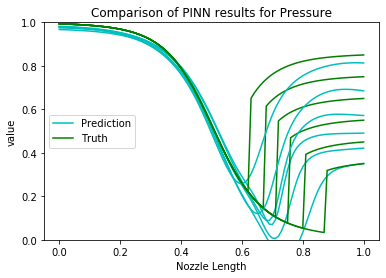

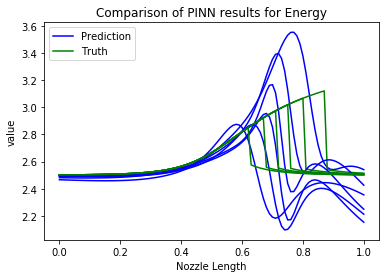

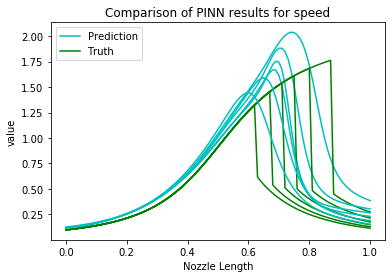

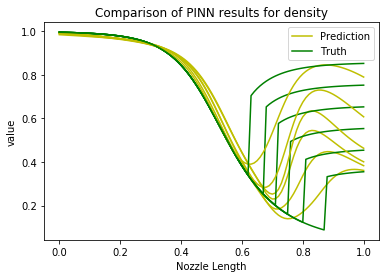

In [51]:
#Plotting
a = 0
b = 6
s = 1
val = 101*a

for i in range (101*a, 101*b, 101*s):
    plt.ylim(0, 1.0)
    plt.plot(x_test[i:i+101], P_test_pred[i:i+101], 'c', label='Prediction' if i == val else "")
    plt.plot(x_test[i:i+101], P_test_dataset[i:i+101], 'g', label='Truth' if i == val else "")
    plt.title('Comparison of PINN results for Pressure')
    plt.xlabel('Nozzle Length')
    plt.ylabel('value')
    plt.legend(loc='center left')
plt.show()

for i in range (101*a, 101*b, 101*s):
    plt.plot(x_test[i:i+101], E_test_pred[i:i+101], 'b', label='Prediction' if i == val else "")
    plt.plot(x_test[i:i+101], E_test_dataset[i:i+101], 'g', label='Truth' if i == val else "")
    plt.title('Comparison of PINN results for Energy')
    plt.xlabel('Nozzle Length')
    plt.ylabel('value')
    plt.legend()
plt.show()

for i in range (101*a, 101*b, 101*s):
    plt.plot(x_test[i:i+101], u_test_pred[i:i+101], 'c', label='Prediction' if i == val else "")
    plt.plot(x_test[i:i+101], u_test_dataset[i:i+101], 'g', label='Truth' if i == val else "")
    plt.title('Comparison of PINN results for speed')
    plt.xlabel('Nozzle Length')
    plt.ylabel('value')
    plt.legend()
plt.show()

for i in range (101*a, 101*b, 101*s):
    plt.plot(x_test[i:i+101], rho_test_pred[i:i+101], 'y', label='Prediction' if i == val else "")
    plt.plot(x_test[i:i+101], rho_test_dataset[i:i+101], 'g', label='Truth' if i == val else "")
    plt.title('Comparison of PINN results for density')
    plt.xlabel('Nozzle Length')
    plt.ylabel('value')
    plt.legend()
plt.show()

In [52]:
# for i in range (101*a, 101*b, 101*s):
#     plt.ylim(0, 0.05)
#     plt.plot(z_test[i:i+101], ((P_test[i:i+101]-P_pred[i:i+101])**2 + (u_test[i:i+101]-u_pred[i:i+101])**2 +
#                                 (E_test[i:i+101]-E_pred[i:i+101])**2 + (rho_test[i:i+101]-rho_pred[i:i+101])**2)/4, 'y', label='PINN Mean square Error')
#     flux1 = (rho_pred*u_pred*S).reshape((606, ))
#     flux2 = ((rho_pred*u_pred**2+ P_pred)*S).reshape((606, ))
#     flux3 = ((rho_pred*E_pred+P_pred)*u_pred*S).reshape((606, ))
#     S = S.reshape((606, ))
#     P_pred = P_pred.reshape((606, ))
#     P_pred = P_pred.reshape((606, ))
#     P_pred = P_pred.reshape((606, ))
#     E_pred = E_pred.reshape((606, ))
#     gamma = 1.4
#     plt.plot(z_test[i:i+101], ((np.gradient(flux1[i:i+101]))**2 +
#                                 (np.gradient(flux2[i:i+101])-P_pred[i:i+101]*np.gradient(S[i:i+101]))**2 +
#                                 (np.gradient(flux3[i:i+101]))**2)/3, 'k', label='PINN Mean square residual')
#     plt.xlabel('Nozzle Length')
#     plt.ylabel('value')
#     plt.legend(loc='center left')
# plt.show()

# #ideal gas eq
# gamma = 1.4
# RHS = rho_pred*(gamma-1)*(E_pred-0.5*u_pred*gamma*u_pred)
# for i in range (101*a, 101*b, 101*s):
#     plt.plot(z_test[i:i+101], RHS[i:i+101], 'kx', label='NN')
#     plt.plot(z_test[i:i+101], P_pred[i:i+101], 'g', label='Truth')
#     plt.title('Ideal Gas Equation')
#     plt.xlabel('Nozzle Length')
#     plt.ylabel('value')
#     plt.legend()
# plt.show()

## Parametric Studies:

Comparison in the quality of predictions of NN and PINN were done and the effect of 3 hyperparameters namely train_frac, layers and w was explored to understand the conditions under which PINN can be significantly useful.

* ### Effect of training fraction on the qualtiy of predictions of NN and PINN for (a) 20% (b) 10% and (c) 5%:
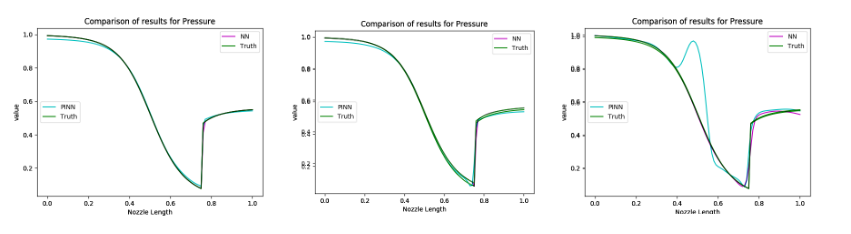

* ### Effect of layers on the qualtiy of predictions of NN and PINN for (a) [2, 15, 25, 15, 4] (b) [2, 10, 10, 10, 4] and (c) [2, 5, 5, 4]:

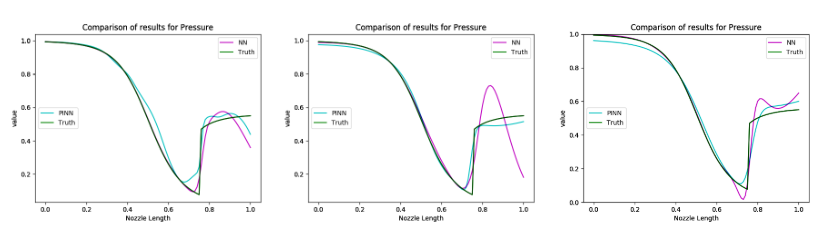

* ### Effect of w on the qualtiy of predictions of NN and PINN for (a) 4 (b) 40 and (c) 400:

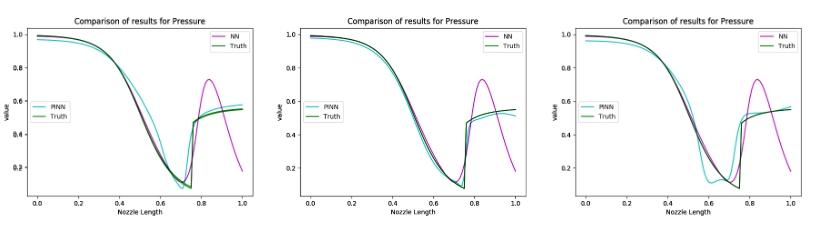

* ### Pressure distribution against test dataset for (a) NN and (b) PINN

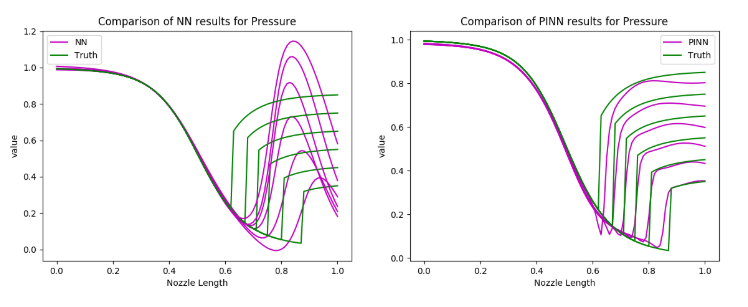